# Comparaisons entre données gouv et data base

In [23]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from scipy.stats import gaussian_kde
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
import os
from sklearn.preprocessing import MinMaxScaler
from matplotlib import rcParams

# Définir Times New Roman comme police par défaut pour tout le graphique
rcParams['font.family'] = 'Times New Roman'

In [24]:
import pandas as pd

df = pd.read_csv("finalbase.csv")
    
# Vérifier si les colonnes nécessaires existent
if 'division' in df.columns and 'siren' in df.columns:
    # Filtrer les entreprises où la division est 72
    filtered_df = df[df['division'] == 72]
    
    # Extraire la colonne SIREN
    siren_list = filtered_df['siren'].tolist()
    
    # Enregistrer les SIREN dans un fichier texte
    with open("siren_list.txt", "w") as f:
        for siren in siren_list:
            f.write(f"{siren}\n")
    
    print("La liste des SIREN a été enregistrée dans 'siren_list.txt'.")
else:
    print("Les colonnes 'division' et/ou 'SIREN' sont absentes du fichier.")

La liste des SIREN a été enregistrée dans 'siren_list.txt'.


Importation de la base gouvernementale

In [25]:
df = pd.read_csv("CIR.csv", sep=';')
data_gov = df[(df['annee'] >= 2016)&(df['annee'] <= 2020)]
print(data_gov.columns)

Index(['annee', '20_21', '26', '29', '30', '22', '25', '24', '19', '13_14_15',
       '32', '10', '33', '62', '71', '45_46_47', '61', '64_65_66', '70', '72',
       '94_95_96', '01_02_03_41_42_43', 'TOTAL', 'ETI_beneficiaire_nbr',
       'ETI_dps_declare', 'ETI_CIR', 'GE_beneficaire_nbr', 'GE_dps_declare',
       'GE_CIR', 'beneficiaire_CIR_nbr'],
      dtype='object')


Importation de la base à nous

In [26]:
our_data = pd.read_csv("finalbase.csv", sep=',')
our_data[['CIR2016', 'CIR2017', 'CIR2018', 'CIR2019', 'CIR2020']] = our_data[['CIR2016', 'CIR2017', 'CIR2018', 'CIR2019', 'CIR2020']].apply(pd.to_numeric, errors='coerce')
our_cir = our_data[(our_data[['CIR2016', 'CIR2017', 'CIR2018', 'CIR2019', 'CIR2020']] > 0).any(axis=1)]
print(our_data.columns)

Index(['Unnamed: 0.1', 'Unnamed: 0', 'siren', 'brevets2016', 'brevets2017',
       'brevets2018', 'brevets2019', 'brevets2020', 'CIR2016', 'CIR2017',
       'CIR2018', 'CIR2019', 'CIR2020', 'Id_ETI', 'dateCreationUniteLegale',
       'division'],
      dtype='object')


# Comparaison des part de bénéficiaire par catégorie

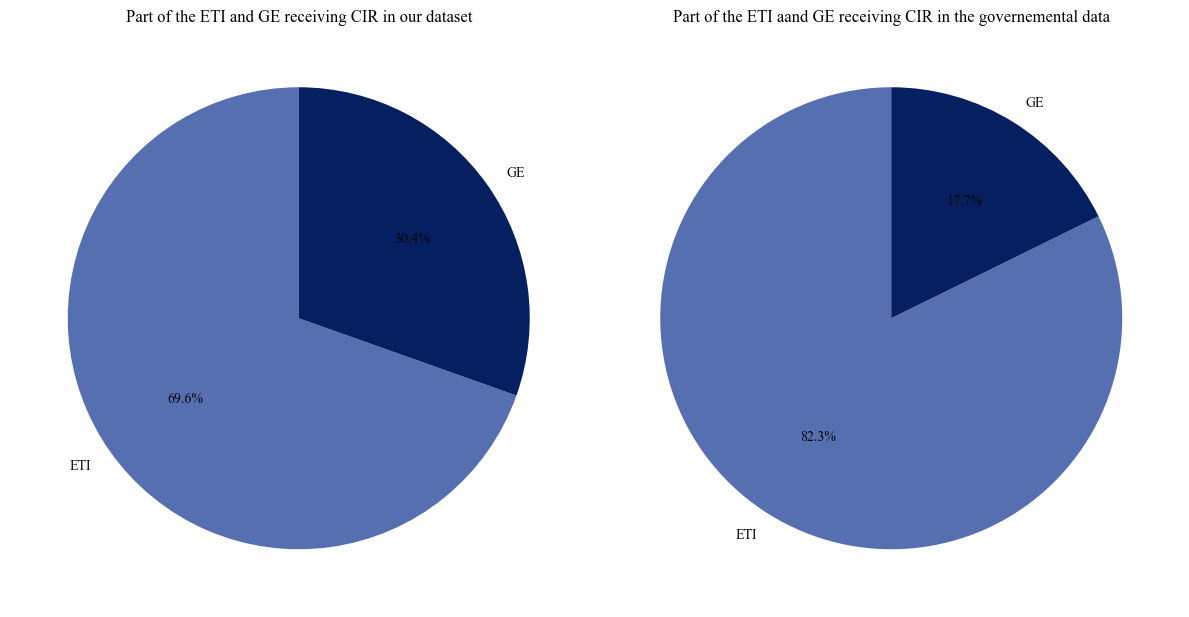

In [27]:
# Initialiser les listes pour stocker les pourcentages annuels
eti_percentages = []
ge_percentages = []

# Années à traiter
years = ['CIR2016', 'CIR2017', 'CIR2018', 'CIR2019', 'CIR2020']

# 1. Itérer sur chaque année
for year in years:
    # Filtrer les entreprises ayant un CIR > 0 pour l'année
    our_data_with_cir = our_data[our_data[year] > 0]

    # 2. Compter le nombre d'ETI et GE ayant reçu un CIR > 0
    eti_with_cir_count = our_data_with_cir[our_data_with_cir['Id_ETI'] == 1].shape[0]
    ge_with_cir_count = our_data_with_cir[our_data_with_cir['Id_ETI'] == 0].shape[0]

    # Ajouter les pourcentages à la liste
    eti_percentages.append(eti_with_cir_count)
    ge_percentages.append(ge_with_cir_count )

# 5. Calculer la moyenne des pourcentages
average_eti = sum(eti_percentages) / len(eti_percentages)
average_ge = sum(ge_percentages) / len(ge_percentages)

# 5. Préparer les données pour le graphique
sizes = [average_eti, average_ge]

# Calculer la somme des bénéficiaires de CIR dans la base gouvernementale
mean_beneficiaires = {
    'ETI': data_gov['ETI_beneficiaire_nbr'].mean(),
    'GE': data_gov['GE_beneficaire_nbr'].mean()
}

# Créer une figure avec deux sous-graphes
fig, axes = plt.subplots(1, 2, figsize=(12, 8))

# Premier graphique : répartition des entreprises
axes[0].pie(
    sizes,
    labels=['ETI', 'GE'],
    autopct='%1.1f%%',
    startangle=90,
    colors=[(86/255,111/255,176/255), (6/255,31/255,96/255)]
)
axes[0].set_title("Part of the ETI and GE receiving CIR in our dataset")

# Deuxième graphique : répartition des montants de CIR
axes[1].pie(
    mean_beneficiaires.values(),
    labels=mean_beneficiaires.keys(),
    autopct='%1.1f%%',
    startangle=90,
    colors=[(86/255,111/255,176/255), (6/255,31/255,96/255)]
)
axes[1].set_title("Part of the ETI aand GE receiving CIR in the governemental data")

# Ajuster l'espace entre les graphiques
plt.tight_layout()
plt.savefig('Comparison of the Part of the ETI aand GE receiving CIR .png', transparent=True)
# Afficher les graphiques
plt.show()

# Comparaison des part de montant par catégorie

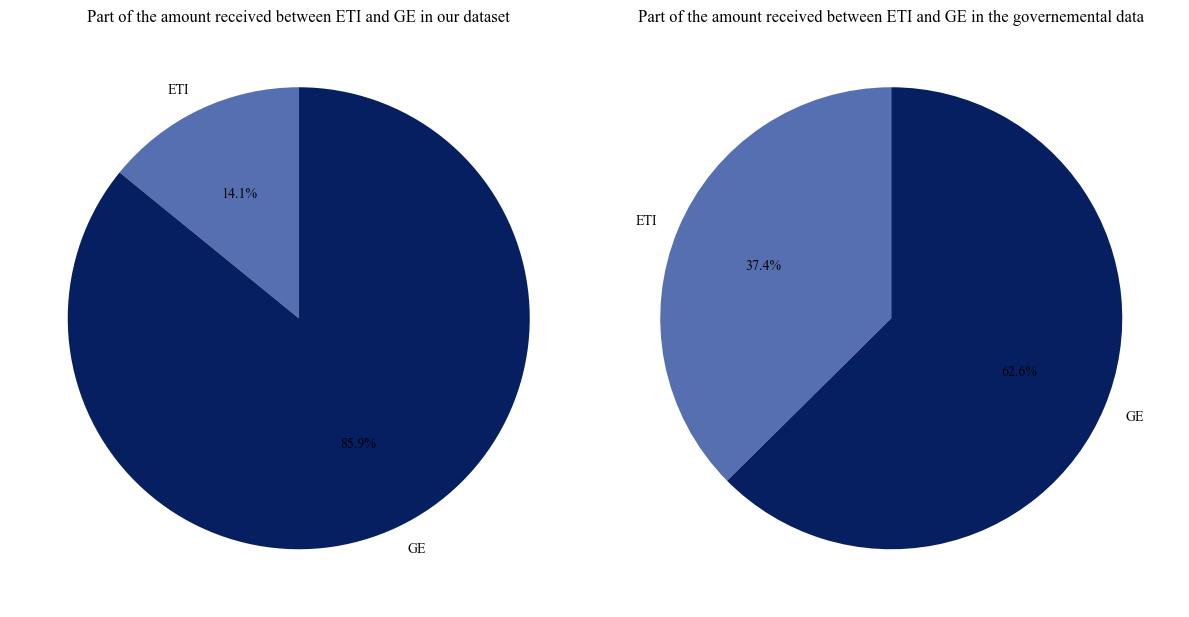

In [28]:
# Filtrer les données pour ETI (Id_ETI = 1) et GE (Id_ETI = 0)
moyenne_eti = our_cir[our_cir['Id_ETI'] == 1][['CIR2016', 'CIR2017', 'CIR2018', 'CIR2019', 'CIR2020']].mean().mean()
moyenne_ge = our_cir[our_cir['Id_ETI'] == 0][['CIR2016', 'CIR2017', 'CIR2018', 'CIR2019', 'CIR2020']].mean().mean()

# Préparer les données pour le pie chart
montants_moyens = [moyenne_eti, moyenne_ge]

# Calculer la somme des bénéficiaires de CIR dans la base gouvernementale
mean_CIR = {
    'ETI': data_gov['ETI_CIR'].mean(),
    'GE': data_gov['GE_CIR'].mean()
}

# Créer une figure avec deux sous-graphes
fig, axes = plt.subplots(1, 2, figsize=(12, 8))

# Premier graphique : répartition des entreprises
axes[0].pie(
    montants_moyens,
    labels=['ETI', 'GE'],
    autopct='%1.1f%%',
    startangle=90,
    colors=[(86/255,111/255,176/255), (6/255,31/255,96/255)]
)
axes[0].set_title("Part of the amount received between ETI and GE in our dataset")

# Deuxième graphique : répartition des montants de CIR
axes[1].pie(
    mean_CIR.values(),
    labels=mean_CIR.keys(),
    autopct='%1.1f%%',
    startangle=90,
    colors=[(86/255,111/255,176/255), (6/255,31/255,96/255)]
)
axes[1].set_title("Part of the amount received between ETI and GE in the governemental data")

# Ajuster l'espace entre les graphiques
plt.tight_layout()
plt.savefig('Comparison of the part of the amount received between ETI and GE.png', transparent=True)
# Afficher les graphiques
plt.show()

 # Comparaison de l'évolution des montant de CIR distribué

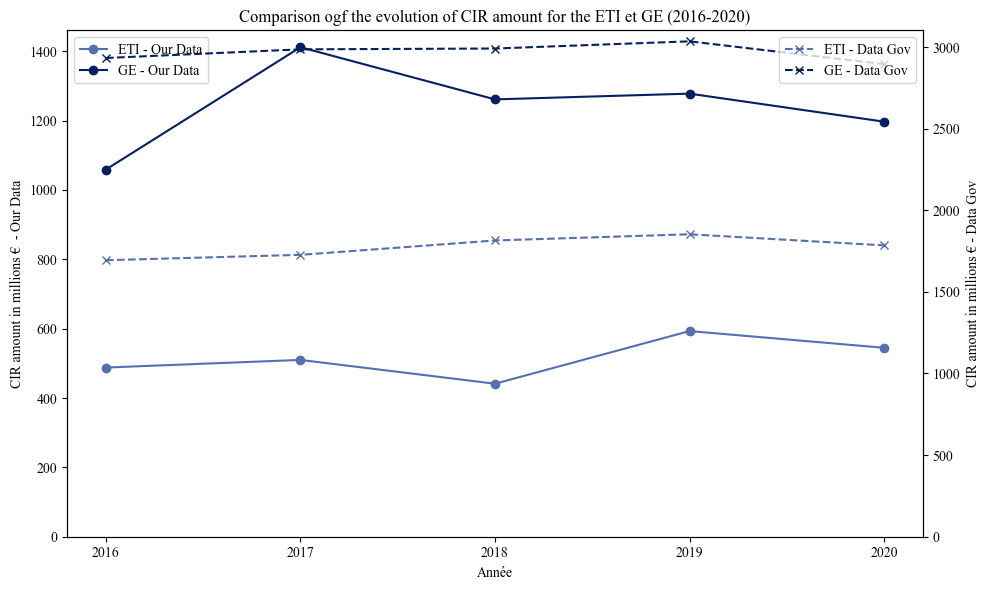

In [29]:
 # 1. Préparation des données dans `our_data` pour chaque année + conversion des montants en millions d'euros
our_data_eti_years = our_data[our_data['Id_ETI'] == 1][['CIR2016', 'CIR2017', 'CIR2018', 'CIR2019', 'CIR2020']].sum()/ 1000000 
our_data_ge_years = our_data[our_data['Id_ETI'] == 0][['CIR2016', 'CIR2017', 'CIR2018', 'CIR2019', 'CIR2020']].sum()/ 1000000 

# 2. Préparation des données dans `data_gov` pour chaque année
data_gov_eti_years = data_gov['ETI_CIR'] 
data_gov_ge_years = data_gov['GE_CIR'] 


# 3. Tracer l'évolution des montants pour les ETI et GE
years = ['2016', '2017', '2018', '2019', '2020']  # Pour `our_data`
# Si les colonnes de `data_gov` sont différentes pour les années, ajustez-les ici.
# Assurez-vous que les années dans `data_gov` correspondent à celles dans `our_data`

fig, ax1 = plt.subplots(figsize=(10, 6))

# Tracer l'évolution des montants pour les ETI et GE dans our_data
ax1.plot(years, our_data_eti_years, label='ETI - Our Data', color=(86/255,111/255,176/255), marker='o')
ax1.plot(years, our_data_ge_years, label='GE - Our Data', color=(6/255,31/255,96/255), marker='o')

# Ajouter des étiquettes pour le premier axe y
ax1.set_xlabel('Année')
ax1.set_ylabel('CIR amount in millions €  - Our Data')
ax1.set_title('Comparison ogf the evolution of CIR amount for the ETI et GE (2016-2020)')
ax1.set_ylim(bottom=0)
# Créer un deuxième axe y pour data_gov
ax2 = ax1.twinx()

# Tracer l'évolution des montants pour les ETI et GE dans data_gov
ax2.plot(years, data_gov_eti_years, label='ETI - Data Gov', color=(86/255,111/255,176/255), linestyle='--', marker='x')
ax2.plot(years, data_gov_ge_years, label='GE - Data Gov', color=(6/255,31/255,96/255), linestyle='--', marker='x')
ax2.set_ylim(bottom=0)
# Ajouter des étiquettes pour le deuxième axe y
ax2.set_ylabel('CIR amount in millions € - Data Gov')

# Afficher la légende
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Afficher le graphique
plt.tight_layout()
plt.savefig('Comparison ogf the evolution of CIR amount for the ETI et GE (2016-2020).png', transparent=True)
plt.show()

# Comparaison du nombre de bénéficaires de CIR 

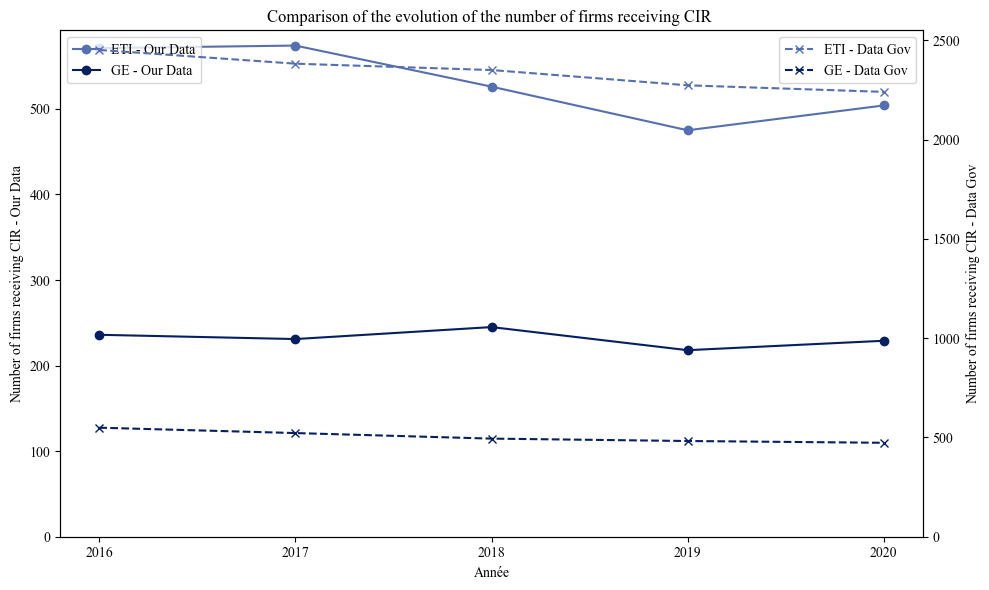

In [30]:
# 1. Préparation des données dans `our_data` pour chaque année
beneficiaires_eti_years = our_cir[our_cir['Id_ETI'] == 1][['CIR2016', 'CIR2017', 'CIR2018', 'CIR2019', 'CIR2020']].gt(0).sum()
beneficiaires_ge_years = our_cir[our_cir['Id_ETI'] == 0][['CIR2016', 'CIR2017', 'CIR2018', 'CIR2019', 'CIR2020']].gt(0).sum()

# 2. Préparation des données dans `data_gov` pour chaque année
# Conversion des montants en millions d'euros pour `data_gov`
data_gov_eti_years = data_gov['ETI_beneficiaire_nbr'] 
data_gov_ge_years = data_gov['GE_beneficaire_nbr']

# 3. Tracer l'évolution des montants pour les ETI et GE
years = ['2016', '2017', '2018', '2019', '2020']  # Pour `our_data`
# Si les colonnes de `data_gov` sont différentes pour les années, ajustez-les ici.
# Assurez-vous que les années dans `data_gov` correspondent à celles dans `our_data`

# Créer le graphique avec deux axes y
fig, ax1 = plt.subplots(figsize=(10, 6))

# Tracer l'évolution des bénéficiaires pour les ETI et GE dans `our_data`
ax1.plot(years, beneficiaires_eti_years, label='ETI - Our Data', color=(86/255,111/255,176/255), marker='o')
ax1.plot(years, beneficiaires_ge_years, label='GE - Our Data', color=(6/255,31/255,96/255), marker='o')

# Ajouter des étiquettes pour le premier axe y
ax1.set_xlabel('Année')
ax1.set_ylabel('Number of firms receiving CIR - Our Data')
ax1.set_title('Comparison of the evolution of the number of firms receiving CIR ')
ax1.set_ylim(bottom=0)
# Créer un deuxième axe y pour `data_gov`
ax2 = ax1.twinx()

# Tracer l'évolution des bénéficiaires pour les ETI et GE dans `data_gov`
ax2.plot(years, data_gov_eti_years, label='ETI - Data Gov', color=(86/255,111/255,176/255), linestyle='--', marker='x')
ax2.plot(years, data_gov_ge_years, label='GE - Data Gov', color=(6/255,31/255,96/255), linestyle='--', marker='x')
ax2.set_ylim(bottom=0)
# Ajouter des étiquettes pour le deuxième axe y
ax2.set_ylabel('Number of firms receiving CIR - Data Gov')

# Afficher la légende
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Afficher le graphique
plt.tight_layout()
plt.savefig('Comparison of the evolution of the number of firms receiving CIR.png', transparent=True)
plt.show()

# Quelle part du total de CIR distribué sur les 5 ans représente notre CIR trouvé ?

Sommme totale de CIR reçu par toutes les entreprises dans notre df: 8784275470.297 €
Sommme totale de CIR reçu par toutes les entreprises dans les donnés governementales : 32525000000 €
Notre database représente 27.007764704986936 du CIR distribué


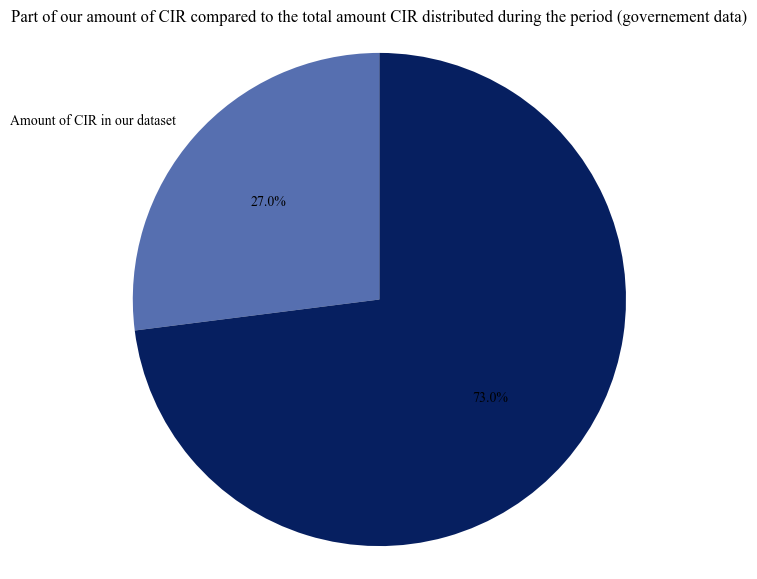

In [31]:
#Calculer la somme totale de CIR reçu par chaque entreprise sur les années 2016 à 2020
total_cir_par_entreprise = our_data[['CIR2016', 'CIR2017', 'CIR2018', 'CIR2019', 'CIR2020']].sum(axis=1)
total_cir_gov= data_gov['TOTAL'].sum()*1000000
# Calculer la somme totale de CIR reçu par toutes les entreprises sur toutes les années
total_cir_all_firms = total_cir_par_entreprise.sum()

print(f"Sommme totale de CIR reçu par toutes les entreprises dans notre df: {total_cir_all_firms} €")
print(f"Sommme totale de CIR reçu par toutes les entreprises dans les donnés governementales : {total_cir_gov} €")
print(f"Notre database représente {(total_cir_all_firms/total_cir_gov)*100} du CIR distribué")

# Calculer le pourcentage du CIR de notre base de données par rapport à la base de données gouvernementale
percentage_our_data = (total_cir_all_firms / total_cir_gov) * 100

# Préparer les données pour le pie chart
sizes = [percentage_our_data, 100 - percentage_our_data]
labels = ['Amount of CIR in our dataset', '']
colors = [(86/255,111/255,176/255), (6/255,31/255,96/255)]

# Créer le graphique en secteurs (pie chart)
fig, ax = plt.subplots(figsize=(7, 7))
ax.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=colors)

# Ajouter un titre
ax.set_title("Part of our amount of CIR compared to the total amount CIR distributed during the period (governement data)")

# Afficher le graphique
plt.axis('equal')  # Pour que le pie chart soit un cercle
plt.savefig('Part of our amount of CIR compared to the total amount CIR distributed during the period (governement data).png', transparent=True)
plt.show()

Sommme totale de CIR reçu par toutes les entreprises dans notre df: 3825624238.0600004 €
Sommme totale de CIR reçu par toutes les entreprises dans les donnés governementales : 32525000000 €
Notre database représente 11.762103729623368 du CIR distribué


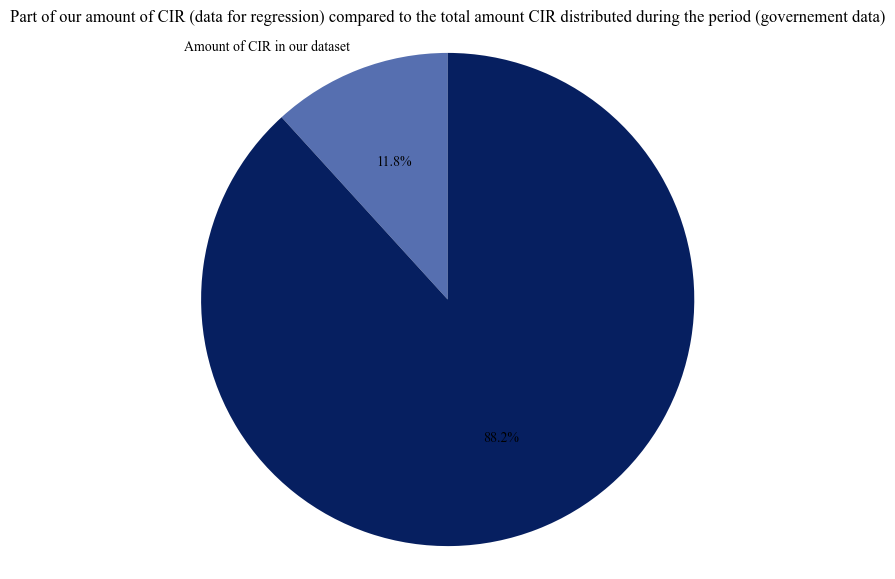

In [32]:
df=pd.read_csv('database238.csv')
#Calculer la somme totale de CIR reçu par chaque entreprise sur les années 2016 à 2020
total_cir_par_entreprise = df[['CIR2016', 'CIR2017', 'CIR2018', 'CIR2019', 'CIR2020']].sum(axis=1)
total_cir_gov= data_gov['TOTAL'].sum()*1000000
# Calculer la somme totale de CIR reçu par toutes les entreprises sur toutes les années
total_cir_all_firms = total_cir_par_entreprise.sum()

print(f"Sommme totale de CIR reçu par toutes les entreprises dans notre df: {total_cir_all_firms} €")
print(f"Sommme totale de CIR reçu par toutes les entreprises dans les donnés governementales : {total_cir_gov} €")
print(f"Notre database représente {(total_cir_all_firms/total_cir_gov)*100} du CIR distribué")

# Calculer le pourcentage du CIR de notre base de données par rapport à la base de données gouvernementale
percentage_our_data = (total_cir_all_firms / total_cir_gov) * 100

# Préparer les données pour le pie chart
sizes = [percentage_our_data, 100 - percentage_our_data]
labels = ['Amount of CIR in our dataset', '']
colors = [(86/255,111/255,176/255), (6/255,31/255,96/255)]

# Créer le graphique en secteurs (pie chart)
fig, ax = plt.subplots(figsize=(7, 7))
ax.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=colors)

# Ajouter un titre
ax.set_title("Part of our amount of CIR (data for regression) compared to the total amount CIR distributed during the period (governement data)")

# Afficher le graphique
plt.axis('equal')  # Pour que le pie chart soit un cercle
plt.savefig('Part of our amount of CIR (data for regression) compared to the total amount CIR distributed during the period (governement data).png', transparent=True)
plt.show()

# Comparaison des CIR amount par sectors reçu 

In [33]:
df_secteur_2016 = data_gov.iloc[:, :22]

df_secteur_2016 = df_secteur_2016.mul(data_gov['TOTAL'], axis=0)  # Multiplier par la colonne Totale
df_secteur_2016 = df_secteur_2016 * 1000000 

# Suppression des lignes indexées de 0 à 6
df_secteur_2016 = df_secteur_2016.transpose()

# Calculer les sommes des colonnes (ignorer la ligne 'annee')
df_secteur_2016['sums'] = df_secteur_2016.iloc[1:].sum(axis=1)
# Remettre la valeur de 'means' à NaN pour la ligne 'annee'
df_secteur_2016.loc['annee', 'sums'] = np.nan

#ranger dans l'ordre croissant
df_sorted = df_secteur_2016['sums'].drop('annee').sort_values(ascending=False)
#Sélectionner les 11 plus gros secteurs
df_top_11 = df_sorted.head(11)


In [34]:
cir_by_division = our_data.groupby('division')[['CIR2016', 'CIR2017', 'CIR2018', 'CIR2019', 'CIR2020']].sum()
# Ajouter une colonne pour la somme totale sur toutes les années
cir_by_division['total_cir'] = cir_by_division.sum(axis=1)

# 1. Assurez-vous que les divisions sont bien des chaînes de caractères
cir_by_division['grouped_division'] = cir_by_division.index.astype(str)

# 2. Créer un mapping des divisions spécifiques
group_mapping = {
    '20': '20_21',
    '21': '20_21',
    '26': '26',
    '29': '29',
    '30':'30', 
    '22':'22',
    '25':'25',
    '24': '24',
    '19':'19',
    '32':'32',
    '10':'10',
    '33':'33',
    '62':'62',
    '71':'71',
    '61':'61',
    '70':'70',
    '72':'72',
    '13': '13_14_15',
    '14': '13_14_15',
    '15': '13_14_15',
    '45': '45_46_47',
    '46': '45_46_47',
    '47': '45_46_47',
    '64': '64_65_66',
    '65': '64_65_66',
    '66': '64_65_66',
    '94': '94_95_96',
    '95': '94_95_96',
    '96': '94_95_96',
    '01': '01_02_03_41_42_43',
    '02': '01_02_03_41_42_43',
    '03': '01_02_03_41_42_43',
    '41': '01_02_03_41_42_43',
    '42': '01_02_03_41_42_43',
    '43': '01_02_03_41_42_43'
}

# 3. Remplacer les divisions selon le mapping
cir_by_division['grouped_division'] = cir_by_division['grouped_division'].replace(group_mapping)

# 4. Regrouper par la colonne 'grouped_division' et calculer la somme du CIR total
cir_by_grouped_division = cir_by_division.groupby('grouped_division')['total_cir'].sum()

# 5. Afficher le résultat trié
cir_by_grouped_division_sorted = cir_by_grouped_division.sort_values(ascending=False)

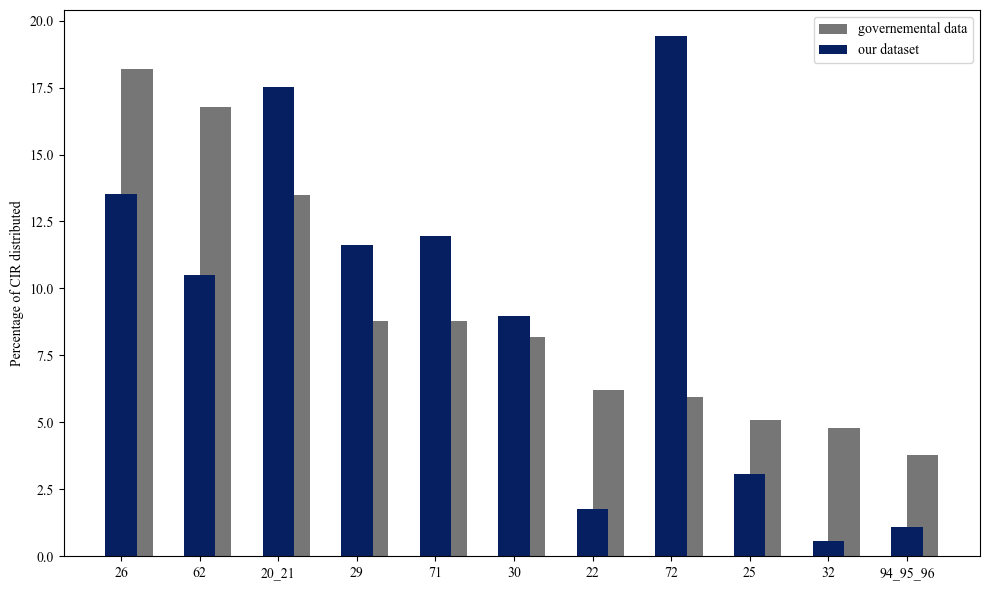

In [35]:
# 1. Assurez-vous que df_top_11 est une série avec les noms des divisions et leurs valeurs
# Je suppose que df_top_11 est déjà trié et est une série avec les indices correspondants aux divisions
# Si df_top_11 est un DataFrame, vous pouvez récupérer la série de la colonne 'sums' par exemple
df_top_11_sorted = df_top_11.sort_values(ascending=False)
# 1. Calculer les parts relatives pour chaque ensemble
cir_by_grouped_division_relative = (cir_by_grouped_division_sorted / cir_by_grouped_division_sorted.sum()) * 100
df_top_11_relative = (df_top_11 / df_top_11.sum()) * 100

# 2. Créer une figure et un axe
fig, ax = plt.subplots(figsize=(10, 6))

# 4. Tracer les deux séries sur le même axe

ax.bar(df_top_11_relative.index, 
        df_top_11_relative.values, 
        color='#767676', width=0.4, 
        label='governemental data', align='edge')

ax.bar(cir_by_grouped_division_relative.index, 
       cir_by_grouped_division_relative.values, 
       color='#061F60', width=0.4, 
       label='our dataset', align='center')

# 5. Ajouter des étiquettes et le titre
ax.set_xlabel('')
ax.set_ylabel('Percentage of CIR distributed')

# 6. Ajouter une légende
ax.legend(loc='upper right')

# 7. Afficher le graphique
plt.tight_layout()
plt.savefig('Comparison of the part of each sectors in the amount of CIR distributed.png', transparent=True)
plt.show()

# Comparaison du nombre d'entreprise par secteurs dans chacune des 4 database

In [36]:
['26', '62', '20', '21', '71', '29', '30', '22', '72', '25', '32', '94', '95', '96']

group_mapping = {
    '20': '20',
    '21': '21',
    '26': '26',
    '29': '29',
    '30':'30', 
    '22':'22',
    '25':'25',
    '32':'32',
    '62':'62',
    '71':'71',
    '72':'72',
    '94': '94',
    '95': '95',
    '96': '96',
}

In [37]:
df1 = pd.read_csv("etablissements_ETI_GE.csv", sep=',')
df2 = pd.read_csv("probable_CIR_ETI_GE.csv", sep=';')
df3 = pd.read_csv("finalbase.csv", sep=',')
df4 = pd.read_csv("database238.csv", sep=',')

df1 = df1[['siren', 'activitePrincipaleUniteLegale']]
df2 = df2[['siren', 'division']]
df3 = df3[['siren', 'division']]
df4 = df4[['siren', 'division']]

print(df1.shape)
print(df2.shape)
print(df3.shape)
print(df4.shape)

C:\Users\lucie\AppData\Local\Temp\ipykernel_8416\599952931.py:1: DtypeWarning: Columns (18,19,20,21,22,23,24,25,26,27,28,42,44,45,48,51,53,54,58,59,60,61,62,63,64,65,68,70,71) have mixed types. Specify dtype option on import or set low_memory=False.
  df1 = pd.read_csv("etablissements_ETI_GE.csv", sep=',')
C:\Users\lucie\AppData\Local\Temp\ipykernel_8416\599952931.py:2: DtypeWarning: Columns (18,19,20,21,22,23,24,25,26,27,28,31,35,42,44,45,48,51,52,53,54,58,59,60,61,62,63,64,65,68,70,71,76,77) have mixed types. Specify dtype option on import or set low_memory=False.
  df2 = pd.read_csv("probable_CIR_ETI_GE.csv", sep=';')


(130361, 2)
(9042, 2)
(2593, 2)
(237, 2)


In [38]:

df1['division'] = df1['activitePrincipaleUniteLegale'].str[:2]
df2['division'] = df2['division'].astype(str)
df3['division'] = df3['division'].astype(str)
df4['division'] = df4['division'].astype(str)

def filter_invalid_divisions(df, group_mapping):
    """
    Supprime les lignes dont la valeur dans la colonne 'division' n'appartient pas aux clés du mapping 'group_mapping'.
    """
    # Filtrer les lignes où la valeur de 'division' est présente dans les clés du mapping
    df_filtered = df[df['division'].isin(group_mapping.keys())]
    return df_filtered

# Appliquer la fonction à chaque DataFrame
df1 = filter_invalid_divisions(df1, group_mapping)
df2 = filter_invalid_divisions(df2, group_mapping)
df3 = filter_invalid_divisions(df3, group_mapping)
df4 = filter_invalid_divisions(df4, group_mapping)

df1['group_division'] = df1['division'].replace(group_mapping)
df2['group_division'] = df2['division'].replace(group_mapping)
df3['group_division'] = df3['division'].replace(group_mapping)
df4['group_division'] = df4['division'].replace(group_mapping)

df1_by_division = df1.groupby('group_division').size()
df2_by_division = df2.groupby('group_division').size()
df3_by_division = df3.groupby('group_division').size()
df4_by_division = df4.groupby('group_division').size()

df1_relative = (df1_by_division / df1_by_division.sum()) * 100
df2_relative = (df2_by_division / df2_by_division.sum()) * 100
df3_relative = (df3_by_division / df3_by_division.sum()) * 100
df4_relative = (df4_by_division / df4_by_division.sum()) * 100


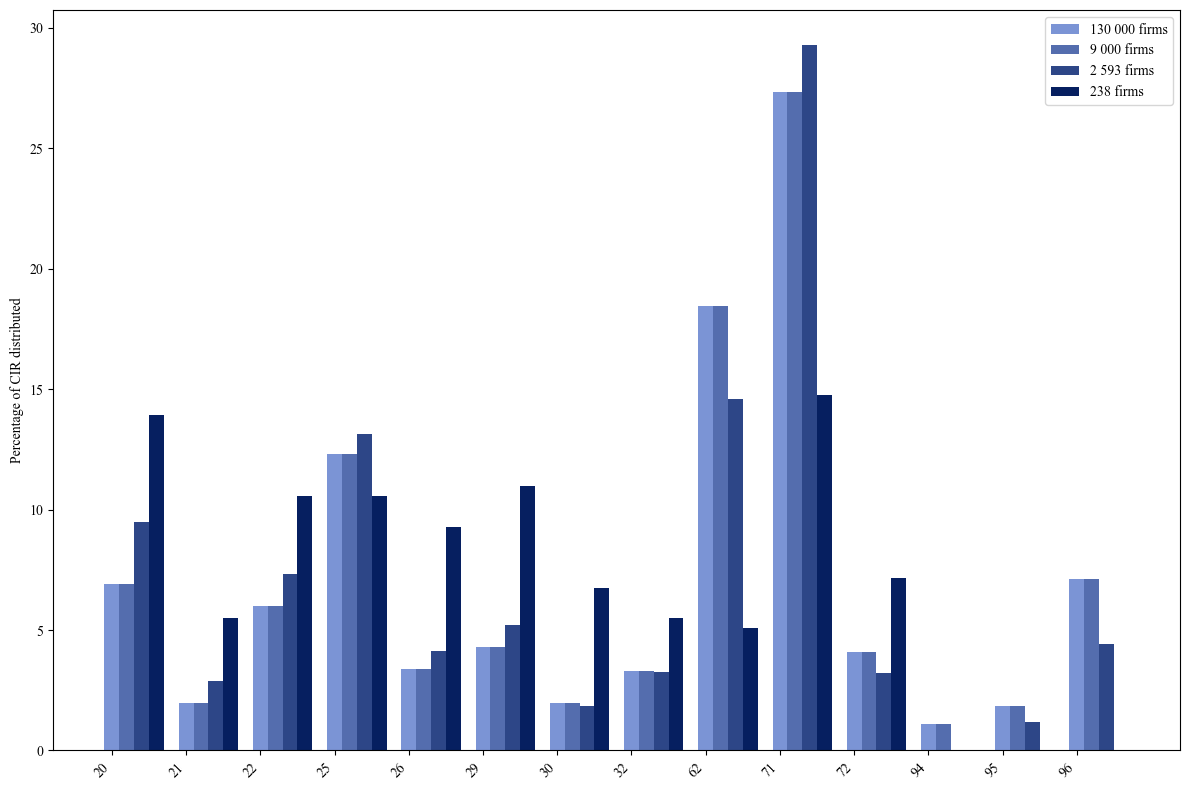

In [39]:
# Aligner les DataFrames sur les indices de df1 pour éviter les erreurs de dimension
df2_relative = df2_relative.reindex(df1_relative.index, fill_value=0)
df3_relative = df3_relative.reindex(df1_relative.index, fill_value=0)
df4_relative = df4_relative.reindex(df1_relative.index, fill_value=0)

positions_df1 = range(len(df1_relative))
positions_df2 = [pos + 0.2 for pos in positions_df1]
positions_df3 = [pos + 0.4 for pos in positions_df1]
positions_df4 = [pos + 0.6 for pos in positions_df1]

# Tracer les barres pour chaque ensemble
fig, ax = plt.subplots(figsize=(12, 8))

ax.bar(positions_df1, 
        df1_relative.values, 
        color=(123/255,148/255,213/255), width=0.2, 
        label='130 000 firms',)

ax.bar(positions_df2, 
        df2_relative.values, 
        color=(84/255,109/255,174/255), width=0.2, 
        label='9 000 firms',)

ax.bar(positions_df3 , 
        df3_relative.values, 
        color=(45/255,70/255,135/255), width=0.2, 
        label='2 593 firms',)

ax.bar(positions_df4, 
        df4_relative.values, 
        color=(6/255,31/255,96/255), width=0.2, 
        label='238 firms',)

# Ajouter des étiquettes, titre et légende
ax.set_xlabel('')
ax.set_ylabel('Percentage of CIR distributed')
ax.set_title('')
ax.set_xticks(positions_df1)  # S'assurer que les positions sont définies
ax.set_xticklabels(df1_relative.index, rotation=45, ha='right')
ax.legend(loc='upper right')

plt.tight_layout()
plt.savefig('Comparison of the part of each sector in the number of firms in the different database.png', transparent=True)
plt.show()